In [1]:
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tm
from src import Simulation as sim
from src import Dir_Reg as DR
from src import ABC_Reg
from src import Align
from src import visualize_latent_space as vls

from CLSNA import congress_utils as CU
from CLSNA.utils import visualize_membership, visualize
from scipy.spatial.distance import squareform

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cuda


In [330]:
def read_parameters(file_path):
    params = {}
    with open(file_path, 'r') as file:
        for line in file:
            name, value = line.strip().split('=')
            params[name] = int(value)  # Convert the value to an integer
    return params

# Read the value of N from the file
parameters = read_parameters('CLSNA/parameters.txt')
N_LEAVE = parameters.get('N_LEAVE')

def plot_lat_pos_CLSNA(df):
    """ the columns of df needs to be "time", "group", "dim_1", "dim_2", ...
    the function will plot the latent position at time 0 and 1"""
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
    # Plot the first heatmap 
    sns.scatterplot(df[df["time"] == 0], ax = axes[0], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
    axes[0].set_title('Scatterplot Z0')
    axes[0].set_xlabel('Columns')
    axes[0].set_ylabel('Rows')
    axes[0].set_xlim(-0.2, 1.1)
    axes[0].set_ylim(-0.2, 1.1)
    # Add x = 0 (vertical line)
    axes[0].axvline(x=0, color='green', linestyle='--')
    # Add y = 0 (horizontal line)
    axes[0].axhline(y=0, color='green', linestyle='--')
    # Add y = 1 - x
    x_vals = np.array(axes[0].get_xlim())
    axes[0].plot(x_vals, 1 - x_vals, color='green', linestyle='--')

    # Plot the second heatmap 
    sns.scatterplot(df[df["time"] == 1], ax = axes[1], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
    axes[1].set_title('Scatterplot Z1')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Rows')
    axes[1].set_xlim(-0.2, 1.1)
    axes[1].set_ylim(-0.2, 1.1)
    # Add x = 0 (vertical line)
    axes[1].axvline(x=0, color='green', linestyle='--')
    # Add y = 0 (horizontal line)
    axes[1].axhline(y=0, color='green', linestyle='--')
    # Add y = 1 - x
    x_vals = np.array(axes[1].get_xlim())
    axes[1].plot(x_vals, 1 - x_vals, color='green', linestyle='--')
    
    
    plt.show()

In [255]:
# Set global variables for the model
N = 2000
DIM = 2
T = 2
SIGMA = 1
TAU = 1
PHI = 1
ALPHA = 1
DELTA = 0
GAMMAW = 0.25
GAMMAB = -0.5

In [256]:
z,y,persist,Aw,Ab,leaves = CU.congress_clsna(N=N, 
                                             d=DIM, 
                                             T=T, 
                                             alpha=ALPHA, 
                                             delta=DELTA, 
                                             sigma=SIGMA, 
                                             tau=TAU , 
                                             phi=PHI, 
                                             gammaw=GAMMAW, 
                                             gammab=GAMMAB, 
                                             n_leave=N_LEAVE)

In [257]:
# t0, t1 = T-9, T-8
t0, t1 = 0, 1

z = torch.tensor(np.array(z))
lat_pos = z[t0:(t1 + 1), :, :]
Z0, Z1 = lat_pos[0, :, :], lat_pos[1, :, :]
Y0, Y1 = torch.as_tensor(squareform(y[t0]), dtype = torch.float32), torch.as_tensor(squareform(y[t1]), dtype = torch.float32)

Visualize the latent position at time t

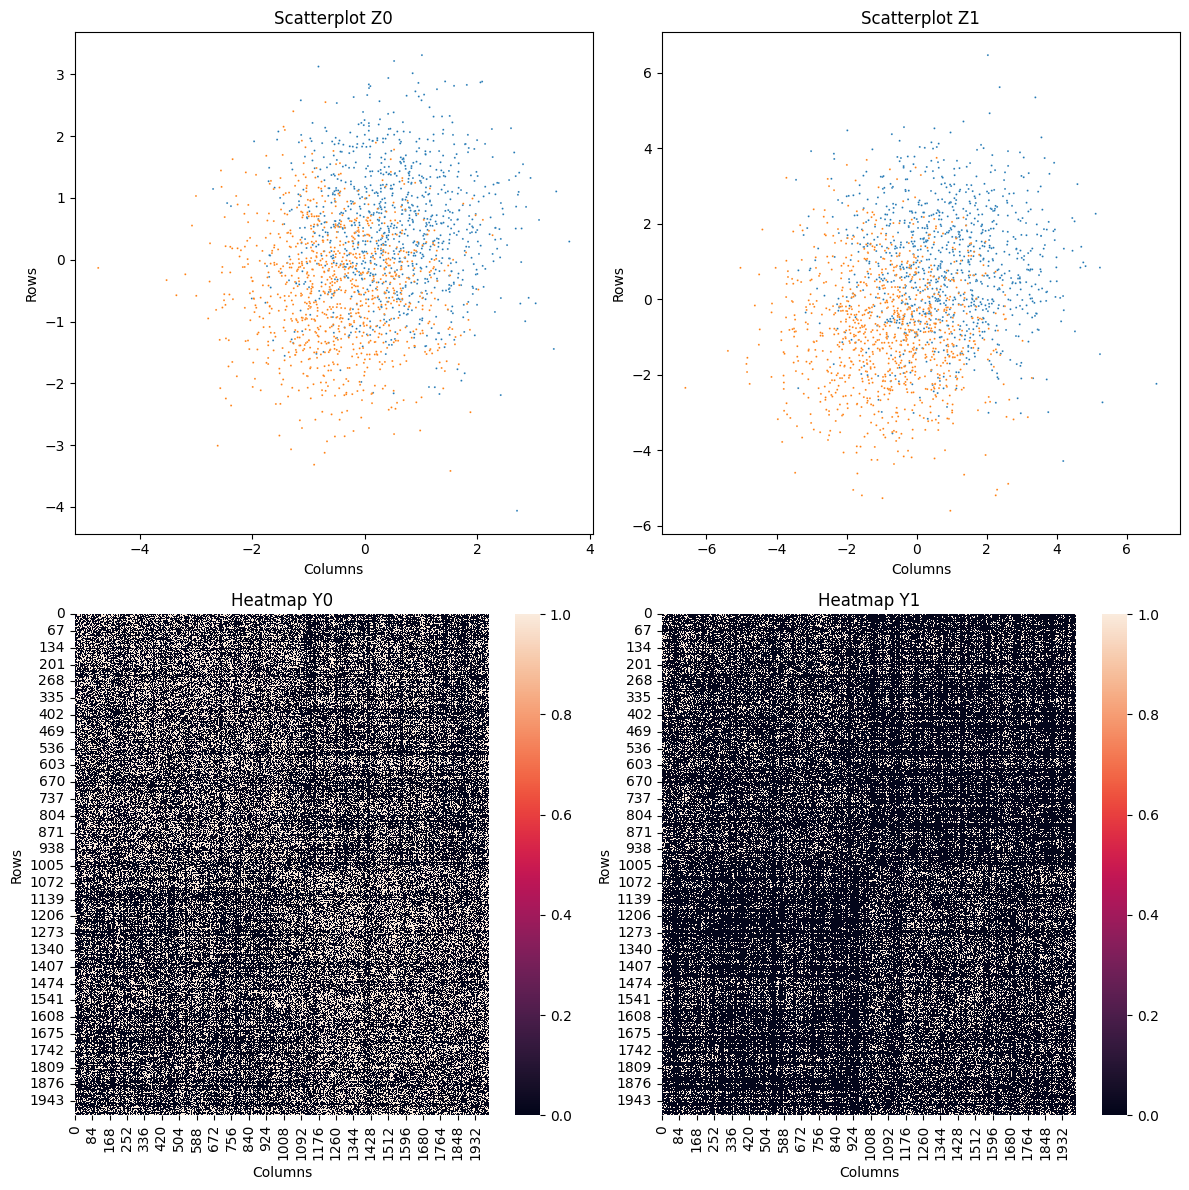

In [258]:
pd_df = sim.ABC_Monte_Carlo.lat_pos(lat_pos, 2)
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjust figsize as needed

# Plot the first heatmap 
sns.scatterplot(pd_df[pd_df["time"] == 0], ax = axes[0,0], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
axes[0,0].set_title('Scatterplot Z0')
axes[0,0].set_xlabel('Columns')
axes[0,0].set_ylabel('Rows')

# Plot the second heatmap 
sns.scatterplot(pd_df[pd_df["time"] == 1], ax = axes[0,1], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
axes[0,1].set_title('Scatterplot Z1')
axes[0,1].set_xlabel('Columns')
axes[0,1].set_ylabel('Rows')

# Plot the first heatmap 
sns.heatmap(Y0, ax=axes[1, 0], cbar=True)
axes[1,0].set_title('Heatmap Y0')
axes[1,0].set_xlabel('Columns')
axes[1,0].set_ylabel('Rows')

# Plot the second heatmap 
sns.heatmap(Y1, ax=axes[1,1], cbar=True)
axes[1,1].set_title('Heatmap Y1')
axes[1,1].set_xlabel('Columns')
axes[1,1].set_ylabel('Rows')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


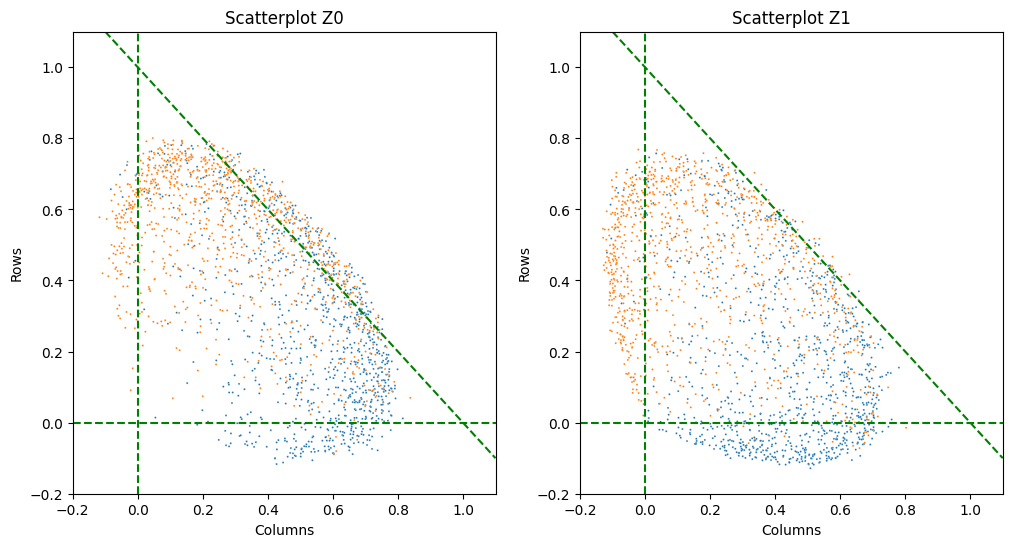

the estimated beta is tensor([ 2.4890, -0.1934, -1.0328, -0.4979]), and the info lost is 0.394


In [341]:
# There are 2 groups, and we want to embed the adjacency matrix in R2
K, p = 2, 2

obs_adj = torch.cat([Y0.unsqueeze(dim=0), Y1.unsqueeze(dim=0)], dim=0)

estimate = ABC_Reg.est(two_adj_mat = obs_adj, groups = K)

estimate.specify_mode("NO", embed_dim= p)

# Here we extract our embeddings and plot them
Aligned = estimate.process("NO") 
Z0_A, Z1_A = Aligned['predictor'][:, 0:2], Aligned['response'][:, 0:2]
Z_Aligned = torch.cat([Z0_A.unsqueeze(dim = 0), Z1_A.unsqueeze(dim = 0)], dim = 0)
temp_df  = sim.ABC_Monte_Carlo.lat_pos(Z_Aligned, 2)

plot_lat_pos_CLSNA(temp_df)

# Print out the estimated beta
estimate.fitted.est_result['estimate']

beta_est = DR.fit.proj_beta(estimate.fitted.est_result["estimate"], DR.fit.gen_constraint(p+1, True))

print(f"the estimated beta is {beta_est}, and the info lost is {estimate.fitted.est_result["info_lost"]}")

In [342]:
# There are 2 groups, and we want to embed the adjacency matrix in R2
K, p0 = 2, 2

obs_adj = torch.cat([Y0.unsqueeze(dim=0), Y1.unsqueeze(dim=0)], dim=0)

estimate = ABC_Reg.est(two_adj_mat = obs_adj, groups = K)
estimate.specify_mode("NO", fit = False,embed_dim= p0)

# # Here we extract our embeddings and plot them
# Aligned = estimate.process("NO") 
# Z0_A, Z1_A = Aligned['predictor'][:, 0:2], Aligned['response'][:, 0:2]  

In [343]:
GD_Z0_Align = Align.GD_RDPG(Y0, 500, estimate.raw_data.Z0_ASE, smoothing = 3.5, tol = 1e-1, verbose = False)
prev_lp = GD_Z0_Align.fitted.clone().detach().to(device)
GD_Z1_Align = Align.GD_RDPG(Y1, 500, prev_lp, smoothing = 3.5, tol = 1e-1, verbose = False)

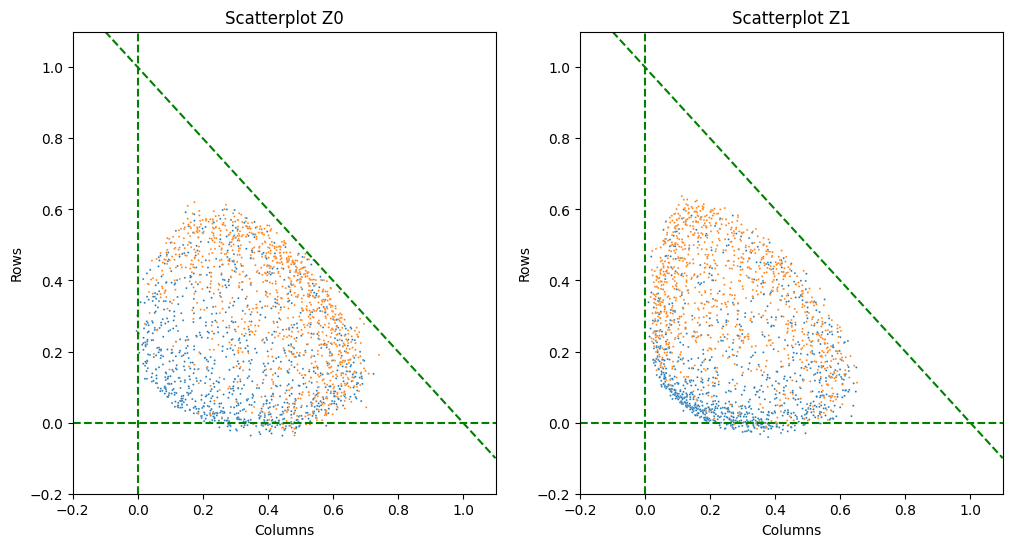

In [344]:
GD_Z_Aligned = torch.cat([GD_Z0_Align.fitted.detach().unsqueeze(dim = 0), GD_Z1_Align.fitted.detach().unsqueeze(dim = 0)], dim = 0).cpu()

temp_df = sim.ABC_Monte_Carlo.lat_pos(GD_Z_Aligned, 2)

plot_lat_pos_CLSNA(temp_df)

